In [91]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from IPython.display import Markdown, display

In [92]:
# Load Temperature Data from NetCDF
temp_ds = xr.open_dataset("C:/Users/VINCENT/Desktop/CAN/Calabar_data.nc")

In [93]:
# Display variable names and coordinates
temp_ds

<xarray.Dataset>
Dimensions:     (valid_time: 720, latitude: 5, longitude: 5)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2025-04-01 ... 2025-04-30T23:00:00
  * latitude    (latitude) float64 5.5 5.25 5.0 4.75 4.5
  * longitude   (longitude) float64 8.0 8.25 8.5 8.75 9.0
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-11T04:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [94]:
# Define bounding box for 1x1 degree around Calabar
lat_bounds = [4.95, 5.0]
lon_bounds = [8.20, 8.25]

In [95]:
# Select the region from the dataset
subset = temp_ds.sel(latitude=slice(*lat_bounds[::-1]), longitude=slice(*lon_bounds))

In [96]:
# Display variable names and coordinates
subset

<xarray.Dataset>
Dimensions:     (valid_time: 720, latitude: 1, longitude: 1)
Coordinates:
    number      int64 ...
  * valid_time  (valid_time) datetime64[ns] 2025-04-01 ... 2025-04-30T23:00:00
  * latitude    (latitude) float64 5.0
  * longitude   (longitude) float64 8.25
    expver      (valid_time) object ...
Data variables:
    t2m         (valid_time, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-05-11T04:38 GRIB to CDM+CF via cfgrib-0.9.1...

In [97]:
# Step 5: Calculate average temperature over time and space
avg_temp = subset['t2m'].mean(dim=['latitude', 'longitude', 'valid_time'])

In [98]:
# Convert from Kelvin to Celsius
avg_temp_celsius = avg_temp - 273.15

display(Markdown(f"### 🌡️ Average Temperature: **{avg_temp_celsius:.2f}°C**"))

### 🌡️ Average Temperature: **27.50°C**

In [99]:
# Load the air quality CSV data
air_quality_df = pd.read_csv("C:/Users/VINCENT/Desktop/CAN/openaq_location_1894640_measurments.csv")

In [100]:
# Preview air quality data
air_quality_df.head()

,location_id,location_name,parameter,value,unit,datetimeUtc,datetimeLocal,timezone,latitude,longitude,country_iso,isMobile,isMonitor,owner_name,provider
0,1894640,Calabar,pm25,9.57,µg/m³,2025-04-01T03:04:54Z,2025-04-01T04:04:54+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
1,1894640,Calabar,pm25,9.09,µg/m³,2025-04-01T03:22:19Z,2025-04-01T04:22:19+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
2,1894640,Calabar,pm25,8.61,µg/m³,2025-04-01T03:39:44Z,2025-04-01T04:39:44+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
3,1894640,Calabar,pm25,9.30,µg/m³,2025-04-01T03:57:10Z,2025-04-01T04:57:10+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity
4,1894640,Calabar,pm25,11.89,µg/m³,2025-04-01T04:14:35Z,2025-04-01T05:14:35+01:00,Africa/Lagos,5.02529,8.34843,NaN,NaN,NaN,Clarity,Clarity


In [101]:
# Convert datetimeUtc to datetime
air_quality_df['datetime'] = pd.to_datetime(air_quality_df['datetimeUtc'])
air_quality_df.set_index('datetime', inplace=True)

In [102]:
# Resample to hourly mean values
pm25_hourly = air_quality_df[air_quality_df['parameter'] == 'pm25']['value'].resample('1h').mean()
pm25_hourly = pm25_hourly.reset_index().rename(columns={'value': 'pm25'})

In [103]:
# Resample to hourly mean values
pm25_hourly['datetime'] = pm25_hourly['datetime'].dt.tz_localize(None)

In [104]:
# Extract average temperature over the 5x5 grid
t2m_mean = temp_ds['t2m'].mean(dim=['latitude', 'longitude'])

# Compute the spatial mean (over lat and lon) for each time step
t2m_df = t2m_mean.to_dataframe().reset_index()

# Merge the datasets again on datetime
t2m_df.rename(columns={'valid_time': 'datetime', 't2m': 'temperature_2m'}, inplace=True)

# Convert to pandas DataFrame
merged_df = pd.merge(t2m_df, pm25_hourly, on='datetime', how='inner')

In [105]:
# Drop NaNs to ensure clean covariance calculation
merged_df_clean = merged_df.dropna(subset=['temperature_2m', 'pm25'])

In [106]:
# Calculate covariance matrix
covariance_matrix = merged_df_clean[['temperature_2m', 'pm25']].cov()
covariance_matrix

,temperature_2m,pm25
temperature_2m,5.867971,-5.081900
pm25,-5.081900,59.572124


In [108]:
# Convert temperature to Celsius for interpretability (optional)
merged_df_clean.loc[:, 'temperature_celsius'] = merged_df_clean['temperature_2m'] - 273.15

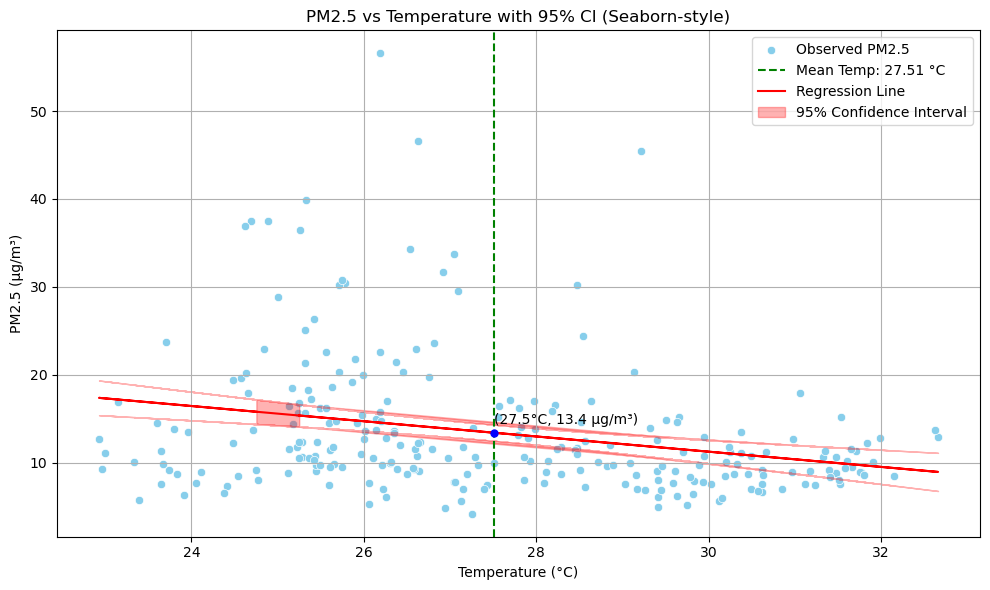

In [109]:
##Plotting line regression fit (with confidence interval like seaborn regplot)

# Sample data
x = merged_df_clean['temperature_celsius']
y = merged_df_clean['pm25']

# Linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
line = slope * x + intercept
avg_temp_celsius = x.mean()
predicted_pm25 = slope * avg_temp_celsius + intercept

# Confidence interval (95%)
X = sm.add_constant(x)  # adds intercept term
model = sm.OLS(y, X).fit()
predictions = model.get_prediction(X)
summary_frame = predictions.summary_frame(alpha=0.05)  # 95% CI

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x, y=y, color='skyblue', label='Observed PM2.5')
plt.axvline(avg_temp_celsius, color='green', linestyle='--', label=f'Mean Temp: {avg_temp_celsius:.2f} °C')
plt.scatter(avg_temp_celsius, predicted_pm25, color='blue', zorder=5, s=25)
plt.plot(x, summary_frame['mean'], color='red', label='Regression Line')
plt.fill_between(x, summary_frame['mean_ci_lower'], summary_frame['mean_ci_upper'],
                 color='red', alpha=0.3, label='95% Confidence Interval')
plt.text(avg_temp_celsius, predicted_pm25 + 1,
         f"({avg_temp_celsius:.1f}°C, {predicted_pm25:.1f} µg/m³)",
         color='black', ha='left')
plt.xlabel('Temperature (°C)')
plt.ylabel('PM2.5 (µg/m³)')
plt.title('PM2.5 vs Temperature with 95% CI (Seaborn-style)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

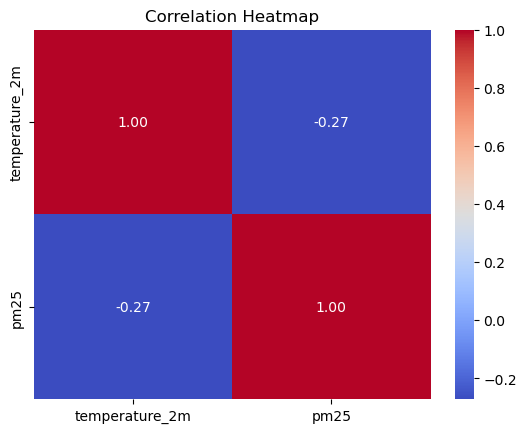

In [113]:
##Heatmap (Correlation Matrix)
corr_matrix = merged_df_clean[['temperature_2m', 'pm25']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

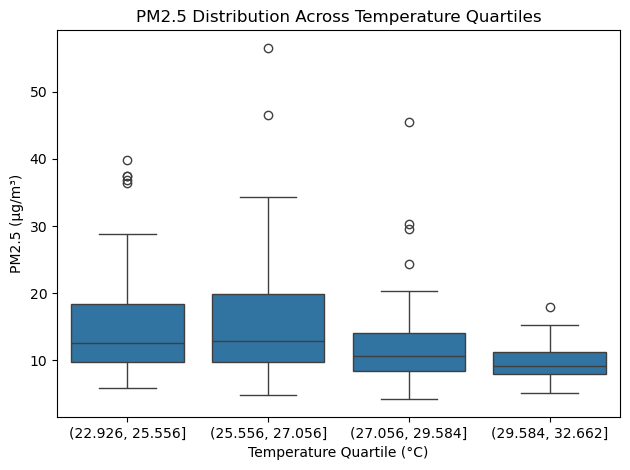

In [112]:
## Box Plot
merged_df_clean.loc[:, 'temp_bin'] = pd.qcut(merged_df_clean['temperature_celsius'], q=4)
sns.boxplot(x='temp_bin', y='pm25', data=merged_df_clean)
plt.xticks(rotation=0)
plt.title("PM2.5 Distribution Across Temperature Quartiles")
plt.xlabel("Temperature Quartile (°C)")
plt.ylabel("PM2.5 (µg/m³)")
plt.tight_layout()
plt.show()